In [ ]:
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import torch

### creating a toy dataset

In [ ]:
X,y = make_circles(n_samples=1000,noise=0.03, random_state=42)

In [ ]:
len(X),len(y)

(1000, 1000)

In [ ]:
print(f"first 5 samples of X:{X[:5]}")
print(f"first 5 samples of y: { y[:5]}")

first 5 samples of X:[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 samples of y: [1 1 1 1 0]


In [ ]:
circles = pd.DataFrame({"X1":X[:,0] ,
                        "X2":X[:,1],
                        "label":y})

In [ ]:
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


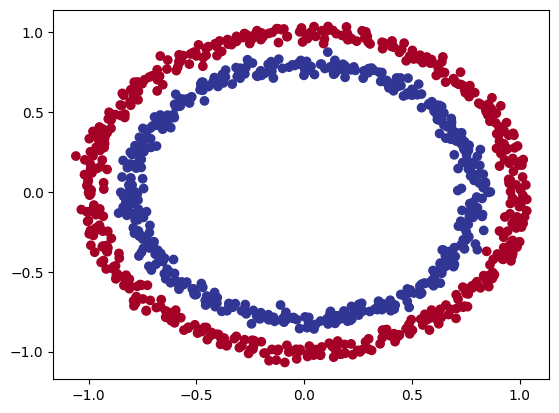

In [ ]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

### turning data into tensors

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
type(X),X.dtype
# type is like asking what kind of container you have
# dtype is like asking what value does the container hold

(torch.Tensor, torch.float32)

In [ ]:
# splitting data into training and testing
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [ ]:
len(X_train),len(X_test), len(y_train),len(y_test)

(800, 200, 800, 200)

# building a model

building a model to classify blue or red

to do so,
1. setup a device agnostic code so our code will run on accelerator (GPU) if there is one.
2. construct a model by subclassing (nn.Module)
3. define a loss function and optimizer
4. create a training and testing loop

In [ ]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# creating a model
### now we have setup device agnostic code, let's create a model

1. subclass nn.Module (almost all model in pytorch subclasses nn.Module)
2. create 2 nn.Linear() layers that are capable of handling the shapes of our data
3. define forward() method that outlines the forward compuatation of the model
4. instantiate our model and send it to the target device

In [ ]:
# 1. create a model that subclass nn.Module

class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()

    # create 2 nn.Linear layers capable of handling the shapes of our data
    # linear layer also called linear transform, probing layer, fully connected layer, dense layer
    self.layer1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
    self.layer2 = nn.Linear(in_features=5, out_features=1) # takes in 5 featurs from previous layer and outputs out 1 feature same shape as y

  # define forward method that outlines the forward pass
  def forward(self,x:torch.Tensor) ->torch.Tensor :
    return self.layer2(self.layer1(x))


# instantiate the model class and send to the target device
model = CircleModel().to(device)
model



CircleModel(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# or we can also use nn.Sequential for easier coding, but we can do more complex computation in our model class

model = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

In [ ]:
model

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3064, -0.2110],
                      [-0.2444,  0.1737],
                      [ 0.5652, -0.4594],
                      [-0.3981,  0.4210],
                      [ 0.6204, -0.7009]])),
             ('0.bias', tensor([ 0.1846, -0.1461,  0.1127,  0.4993,  0.2187])),
             ('1.weight',
              tensor([[ 0.4395,  0.3567, -0.3300, -0.2479, -0.0266]])),
             ('1.bias', tensor([-0.4383]))])

In [ ]:
# making predictions
model.eval()

with torch.inference_mode():
  untrained_preds = model(X_test.to(device))
  print(f"length of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}")
  print(f"length of test samples: {len(X_test)}, shape: {X_test.shape}")
  print(f"\n first 10 predictions {untrained_preds[:10]}")
  print(f"\n first 10 labels {y_test[:10]}")

length of predictions: 200, shape: torch.Size([200, 1])
length of test samples: 200, shape: torch.Size([200, 2])

 first 10 predictions tensor([[-0.4298],
        [-0.5474],
        [-0.3579],
        [-0.4492],
        [-0.7335],
        [-0.8024],
        [-0.8360],
        [-0.8967],
        [-0.3422],
        [-0.5595]])

 first 10 labels tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


# setup loss function and optimizer
which loss function or optimizer should you use?

again the problem is specific,

for regression problem we might use MAE(l1) and MSE(l2)

for classification we might want to use binary cross entory or

categorical cross entopy

As a reminder, a loss funciton mesures how *wrong* the predictions are

and for optimizers, two most common and useful are SGD and Adam

for loss we are going to use torch.nn.BCEWithLogitsLoss()


In [ ]:
loss_fn = nn.BCEWithLogitsLoss() # it has sigmoid activation funciton built in

optimizer = torch.optim.SGD(model.parameters(),lr=0.1)

In [ ]:
def accuracy_fn(y_true,y_preds):
  correct = torch.eq(y_true,y_preds).sum().item()
  acc= (correct/len(y_preds))*100
  return acc

# Train the model

to train our model, we are going to build a training loop:

1. forward pass
2. calculate the loss
3. optimizer zero grad
4. loss backward (back propagation)
5. optimization step (gradient descent)

our model output are going to be raw logits

going from raw logits -> prediction probabilites -> prediction labels

we can convert these **logits** into prediction probabilities by pasing them to some kind of activation function (eg. sigmoid for binary classification and softmax for multiclass classification)

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the argmax()


### analogy on model.eval() and inference_mode()
**model.eval()**: Imagine a machine learning model as a student. When the student is in "training mode," they are practicing with a tutor who gives immediate feedback and corrects mistakes. When the student is in "evaluation mode," they are taking an exam where they apply what they've learned without receiving feedback.

**torch.inference_mode()**: During an exam, the student's answers are final, and no corrections or adjustments are made. This mode ensures the evaluation is efficient and focused solely on generating answers without any background calculations for corrections.

In [ ]:
model.eval()
with torch.inference_mode():
  y_logits = model(X_test.to(device))[:5]
y_logits

tensor([[-0.4298],
        [-0.5474],
        [-0.3579],
        [-0.4492],
        [-0.7335]])

In [ ]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs , y_test[:5]

(tensor([[0.3942],
         [0.3665],
         [0.4115],
         [0.3896],
         [0.3244]]),
 tensor([1., 0., 1., 0., 1.]))

In [ ]:
# find the predicted label

y_preds =   torch.round(y_pred_probs)

# in full
y_preds_label = torch.round(torch.sigmoid(model(X_test.to(device))))

In [ ]:
y_preds_label.shape

torch.Size([200, 1])

# building the training and testin loop

In [ ]:
torch.manual_seed(42)

# set the number of epochs
epochs = 100

# put the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# build training and evaluating loop
for epoch in range(epochs):

  # 1 train the model
  model.train()

  # 2 forward pass
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 3 calculate loss/ accuracy
  loss = loss_fn(y_logits,
                 y_train)

  acc= accuracy_fn(y_true=y_train,
                   y_preds= y_pred)

  # 4 optimizer (clears old gradients)
  optimizer.zero_grad()

  # 5 loss backward (backpropagation)
  loss.backward()

  # 6 optimizer step (gradient descent) (performs a parameter update)
  optimizer.step()

  # testing
  model.eval()
  with torch.inference_mode():
    # forward pass
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate the test loss/ accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_preds = test_pred)

    # print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch : {epoch}  loss {loss:.5f}  acc:{acc:.2f}%  test loss:{test_loss:.5f} test acc:{test_acc:.2f}%")



Epoch : 0  loss 0.73975  acc:50.00%  test loss:0.73256 test acc:50.00%
Epoch : 10  loss 0.71455  acc:50.00%  test loss:0.70952 test acc:50.00%
Epoch : 20  loss 0.70398  acc:44.38%  test loss:0.69975 test acc:45.00%
Epoch : 30  loss 0.69938  acc:45.25%  test loss:0.69546 test acc:49.00%
Epoch : 40  loss 0.69726  acc:46.75%  test loss:0.69350 test acc:51.00%
Epoch : 50  loss 0.69620  acc:48.25%  test loss:0.69256 test acc:51.00%
Epoch : 60  loss 0.69560  acc:47.88%  test loss:0.69210 test acc:52.50%
Epoch : 70  loss 0.69523  acc:47.75%  test loss:0.69186 test acc:52.50%
Epoch : 80  loss 0.69496  acc:48.38%  test loss:0.69174 test acc:52.50%
Epoch : 90  loss 0.69475  acc:49.00%  test loss:0.69169 test acc:52.00%


In [ ]:
import requests
from os import path

if path.exists("helper_functions.py"):
  print("helper function exists")

else :
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


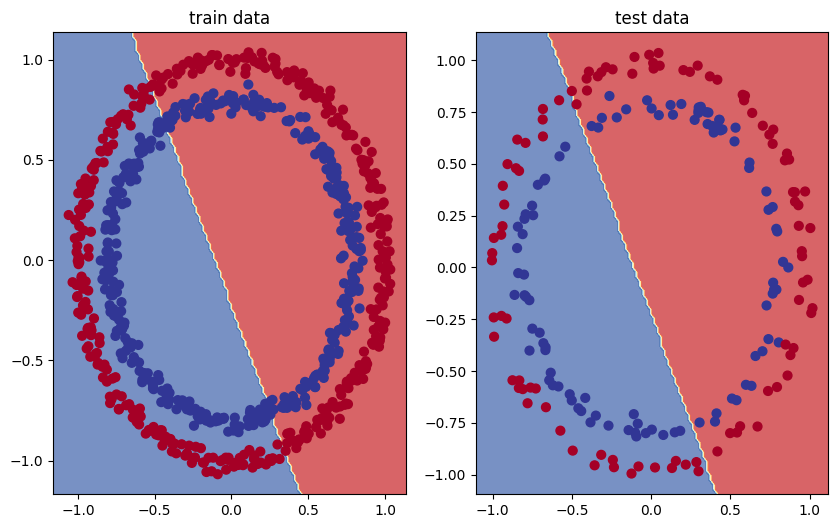

In [ ]:
plt.figure
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title("train data")
plot_decision_boundary(model,X_train,y_train)

plt.subplot(1,2,2)
plt.title("test data")
plot_decision_boundary(model,X_test,y_test)


## improving a model(from a model perspective)
our linear transformers doesn't seem to be working well,
modifying our model parameters to see if it gets better.

Here are some ways we can achieve this:
* add more layers
* add more hidden units
* fit for longer
* changing the activation functions
* change the learning rate
* change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)

  def forward(self,x:torch.Tensor)->torch.Tensor:
    # z = self.layer1(x)
    # z = self.layer2(z)
    # z = self.layer3(z)
    # return z
    return self.layer3(self.layer2(self.layer1(x)))

model1 = CircleModelV1().to(device)
model1


CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# creating a loss function
loss_fn = nn.BCEWithLogitsLoss()

# creating an optimizer
optimizer_fn = torch.optim.SGD(params = model1.parameters(),lr=0.1)

In [ ]:
torch.manual_seed(42)

epochs = 1000

X_train,y_train,X_test,y_test = X_train.to(device),y_train.to(device),X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  ## training
  model1.train()

  ## forward pass
  y_logits = model1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate loss and accuracy
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true = y_train, y_preds=y_pred)

  # optimizer
  optimizer.zero_grad()

  # loss backward ( backpropagation)
  loss.backward()

  #optimizer step (gradient descent)
  optimizer.step()

  # testing
  model1.eval()
  with torch.inference_mode():
    # forward pass
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate loss
    loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_preds=test_pred, y_true= y_test)

    if epoch % 100 ==0:
      print(f"epoch {epoch}  loss:{loss:.5f},  acc:{acc:.2f}%  test loss:{test_loss:.5f}, test acc:{test_acc:.2f}%")

epoch 0  loss:0.69167,  acc:50.88%  test loss:0.69167, test acc:52.00%
epoch 100  loss:0.69167,  acc:50.88%  test loss:0.69167, test acc:52.00%
epoch 200  loss:0.69167,  acc:50.88%  test loss:0.69167, test acc:52.00%
epoch 300  loss:0.69167,  acc:50.88%  test loss:0.69167, test acc:52.00%
epoch 400  loss:0.69167,  acc:50.88%  test loss:0.69167, test acc:52.00%
epoch 500  loss:0.69167,  acc:50.88%  test loss:0.69167, test acc:52.00%
epoch 600  loss:0.69167,  acc:50.88%  test loss:0.69167, test acc:52.00%
epoch 700  loss:0.69167,  acc:50.88%  test loss:0.69167, test acc:52.00%
epoch 800  loss:0.69167,  acc:50.88%  test loss:0.69167, test acc:52.00%
epoch 900  loss:0.69167,  acc:50.88%  test loss:0.69167, test acc:52.00%


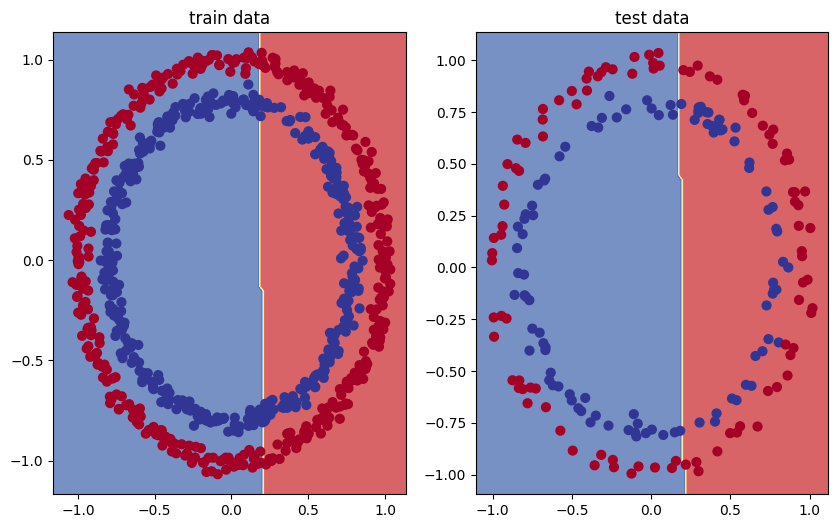

In [ ]:
# plot the decision boundry

plt.figure
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title("train data")
plot_decision_boundary(model1,X_train,y_train)

plt.subplot(1,2,2)
plt.title("test data")
plot_decision_boundary(model1,X_test,y_test)

### our new imporoved model also doesn't seem to be working well.

## Non liear model
imporoving the model by adding more layers and increasing epoches didn't help.

So now building a model by introducting non linear activation to our linear transformation

In [ ]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x:torch.Tensor)->torch.Tensor:
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model2 = CircleModelV2().to(device)
model2

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# creating a loss and optimizer function

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model2.parameters(),
                               lr=0.1)

In [ ]:
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

In [ ]:
#training the  model
torch.manual_seed(42)
epochs=2000

for epoch in range(epochs):
  # train the model first
  model2.train()

  # forward pass
  y_logits = model2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # checkin the loss
  loss = loss_fn(y_logits ,y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_preds=y_pred)

  # optimizer zero grad
  optimizer.zero_grad()

  loss.backward()

  #optimizer step (gradient descent)
  optimizer.step()

  # testing
  model2.eval()
  with torch.inference_mode():
    # forward pass
    test_logits = model2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_preds=test_pred, y_true=y_test)

    if epoch % 100 ==0:
      print(f"epoch {epoch}  loss:{loss:.5f},  acc:{acc:.2f}%  test loss:{test_loss:.5f}, test acc:{test_acc:.2f}%")



epoch 0  loss:0.69295,  acc:50.00%  test loss:0.69319, test acc:50.00%
epoch 100  loss:0.69115,  acc:52.88%  test loss:0.69102, test acc:52.50%
epoch 200  loss:0.68977,  acc:53.37%  test loss:0.68940, test acc:55.00%
epoch 300  loss:0.68795,  acc:53.00%  test loss:0.68723, test acc:56.00%
epoch 400  loss:0.68517,  acc:52.75%  test loss:0.68411, test acc:56.50%
epoch 500  loss:0.68102,  acc:52.75%  test loss:0.67941, test acc:56.50%
epoch 600  loss:0.67515,  acc:54.50%  test loss:0.67285, test acc:56.00%
epoch 700  loss:0.66659,  acc:58.38%  test loss:0.66322, test acc:59.00%
epoch 800  loss:0.65160,  acc:64.00%  test loss:0.64757, test acc:67.50%
epoch 900  loss:0.62362,  acc:74.00%  test loss:0.62145, test acc:79.00%
epoch 1000  loss:0.56818,  acc:87.75%  test loss:0.57378, test acc:86.50%
epoch 1100  loss:0.48153,  acc:93.50%  test loss:0.49935, test acc:90.50%
epoch 1200  loss:0.37056,  acc:97.75%  test loss:0.40595, test acc:92.00%
epoch 1300  loss:0.25458,  acc:99.00%  test loss:0

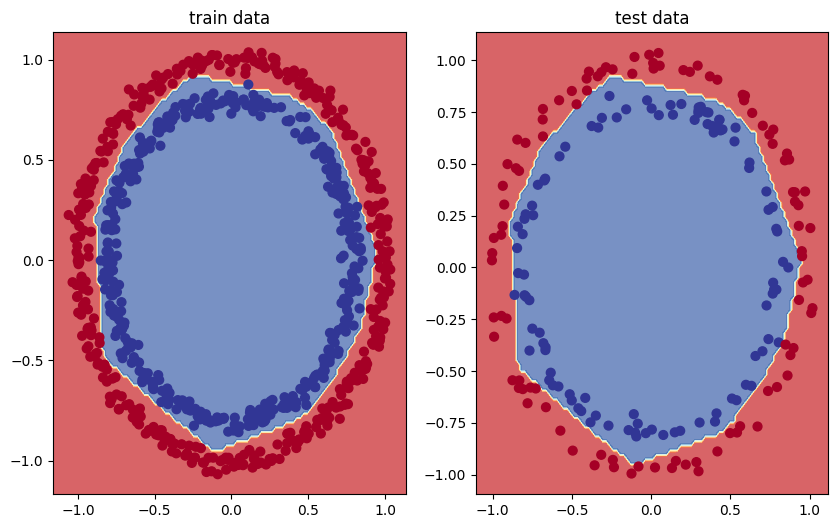

In [ ]:
# plot the decision boundry

plt.figure
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title("train data")
plot_decision_boundary(model2,X_train,y_train)

plt.subplot(1,2,2)
plt.title("test data")
plot_decision_boundary(model2,X_test,y_test)

In [ ]:
torch.save(obj = model2.state_dict(),f="model.pt")